# mnist-explanation

In this notebook, I try to implement explanation methods as described by G. Montavon et al. in their paper `Methods for Interpreting and Understanding Deep Neural Networks` [1]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm, trange

In [2]:
mean, std = (0.1307, 0.3081)
transforms = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((mean,), (std,))
                             ])

In [3]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

In [4]:
testset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

Image Dimension: torch.Size([28, 28])


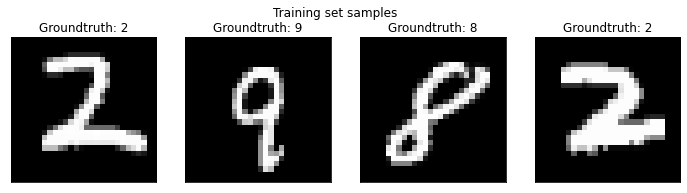

In [5]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

fig, ax = plt.subplots(1,4)
fig.suptitle('Training set samples')
fig.set_size_inches(12,3)
for i in range(images.shape[0]):
    ax[i].imshow(images[i][0], cmap='gray')
    ax[i].set_title('Groundtruth: {}'.format(labels[i].item()))
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
print('Image Dimension: {}'.format(images[0][0].shape))

## Neural Network Implementation

In their original paper, the researchers do not explicit the structure of the Deep Neural Network (DNN) used in the scope of their study, but only mention a composition of convolutional and fully-connected layers. As such, I will be using a very simple CNN: 2 convolutional layers with associated max-pooling layers followed by 3 fully-connected layers, using the RELU activation function.

In [6]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


dnn = DNN()
print(dnn)

DNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


I use the Adam optimiser (using PyTorch default values) together with the Categorical Cross-Entropy loss function, over 10 epochs.

In [7]:
opt = torch.optim.Adam(dnn.parameters())
cce = nn.CrossEntropyLoss()
epochs = 10

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/15000 [00:00<?, ?it/s]

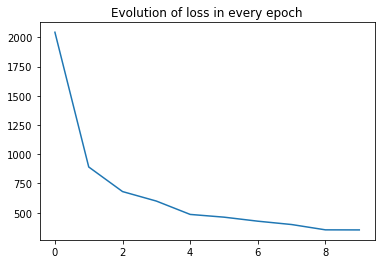

In [8]:
# Training
losses = np.zeros(epochs)
for epoch in trange(epochs, desc='Epochs'):
    epoch_loss = 0.0
    for data in tqdm(trainloader, desc='Epoch {}'.format(epoch)):
        inputs, labels = data
        opt.zero_grad()
        outputs = dnn(inputs)
        loss = cce(outputs, labels)
        loss.backward()
        opt.step()
        epoch_loss += loss.item()
    losses[epoch] = epoch_loss
        
plt.plot(losses)
plt.title('Evolution of loss in every epoch')
plt.show()

In [10]:
correct = 0
total = 0
with torch.no_grad():
    for data in tqdm(testloader, desc='Testing'):
        images, labels = data
        outputs = dnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the {} test images: {:2}%'.format(total, 100.*correct/total))

Testing:   0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 98.69%


With 98.69% accuracy over the test set, the result is judged satisfactory enough to be used in the explanation framework.

## References

[1] Grégoire Montavon, Wojciech Samek, Klaus-Robert Müller, Methods for interpreting and understanding deep neural networks, Digital Signal Processing, Volume 73, 2018, Pages 1-15, ISSN 1051-2004, https://doi.org/10.1016/j.dsp.2017.10.011. (https://www.sciencedirect.com/science/article/pii/S1051200417302385)